In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import sys

import numpy as np
import pandas as pd
import random
import glob
from PIL import Image
from keras.models import load_model
from keras.models import Model


Using TensorFlow backend.


### Make function to generate predictions for a given image using the two stage and one stage methods

In [2]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*
from heat_models import*
import matplotlib.pyplot as plt
% matplotlib inline


def create_heatmap_2(image_loc, model, height, downsample):
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    image = np.array(Image.open(image_loc))
    image_shape = image.shape
    image = image/255.0 # During training the images were normalized
    height = int(height)

#     model = load_model(model_loc)
    last = model.layers[-2].output
    model = Model(model.input, last)

    out_shape = np.ceil(np.array(image.shape)/float(downsample)).astype(int)
    out_shape[2] = 4 # there are 4 classes

    delta=int((height)/2)
    image = np.lib.pad(image, ((delta, delta-int(downsample)), (delta, delta-int(downsample)), (0,0)), 'constant', constant_values=(0, 0))
    image = np.expand_dims(image, axis=0)
    heat = model.predict(image, batch_size=1, verbose=0)
    heat = np.reshape(heat, out_shape)
    
    # now apply the softmax to only the 3 classes(not the overall class probability (why??))
    heat[:,:,1:] = np.apply_along_axis(softmax, 2, heat[:,:,1:])
    
    return heat


def test_heat_preds(test_folder, heat_folder, radius, cutoff, output_class, stride):
    all_files=glob.glob(os.path.join(test_folder, '*'))
    all_xml = [loc for loc in all_files if 'key' in loc]
    all_matched_pts = []
    all_matched_preds = []
    abs_error_list = []
    total_nuclei = 0
    num_predicted =0

    for xml_loc in all_xml:
        image_name = xml_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
        heat_loc = os.path.join(heat_folder, image_name+'_crop.npy')

        acc = get_matched_pts(xml_loc, heat_loc, radius, cutoff, output_class, stride)

        # Update 
        all_matched_preds.extend(np.array(acc["all_matched_preds"]))
        all_matched_pts.extend(np.array(acc["all_matched_pts"]))

        total_nuclei = total_nuclei + acc['total_nuclei']
        num_predicted = num_predicted + acc['num_predicted']
        abs_error_list.append(acc['abs_error'])

    acc_dict = {}
    acc_dict["all_matched_preds"] = np.array(all_matched_preds)
    acc_dict["all_matched_pts"] = np.array(all_matched_pts)
    acc_dict["total_nuclei"] = total_nuclei
    acc_dict["num_predicted"] = num_predicted
    acc_dict["abs_error"] = np.mean(abs_error_list)
    return acc_dict


def get_matched_pts2(true_points, preds, radius, cutoff, output_class, stride, im_size):
    all_matched_pts = []
    all_matched_preds = []
    total_nuclei = 0
    num_predicted =0

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points
    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
    acc_dict = {}
    acc_dict["all_matched_preds"] = np.array(all_matched_preds)
    acc_dict["all_matched_pts"] = np.array(all_matched_pts)
    acc_dict["total_nuclei"] = len(true_points)
    acc_dict["num_predicted"] = len(preds)
    acc_dict["abs_error"] = abs(len(true_points)-len(preds))
    return acc_dict   


def test_heat_preds_2stage(test_folder, heat_folder, model, radius, cutoff, output_class, stride, im_size):
    all_files=glob.glob(os.path.join(test_folder, '*'))
    all_xml = [loc for loc in all_files if 'key' in loc]
    all_matched_pts = []
    all_matched_preds = []
    abs_error_list = []
    total_nuclei = 0
    num_predicted =0

    for xml_loc in all_xml:
        image_name = xml_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
        heat_loc = os.path.join(heat_folder, image_name+'_crop.npy')
        test_loc = os.path.join(test_folder, image_name+'_crop.tif')

        heat = np.load(heat_loc)
        image = np.asarray(Image.open(test_loc))
        print('test_loc ', test_loc)
        print('image.shape', image.shape)


        # get predictions and actual nuclei
        true_points = get_points_xml(xml_loc)
        point_list = non_max_supression(heatmap=heat, radius=radius, cutoff = cutoff, stride = stride)
        preds = predict_points(point_list, model, image, im_size)
        true_pts = get_points_xml(xml_loc)

        acc = get_matched_pts2(true_points, preds, radius, cutoff, output_class, stride, im_size)
        # Update 
        all_matched_preds.extend(np.array(acc["all_matched_preds"]))
        all_matched_pts.extend(np.array(acc["all_matched_pts"]))

        total_nuclei = total_nuclei + acc['total_nuclei']
        num_predicted = num_predicted + acc['num_predicted']
        abs_error_list.append(acc['abs_error'])

    acc_dict = {}
    acc_dict["all_matched_preds"] = np.array(all_matched_preds)
    acc_dict["all_matched_pts"] = np.array(all_matched_pts)
    acc_dict["total_nuclei"] = total_nuclei
    acc_dict["num_predicted"] = num_predicted
    acc_dict["abs_error"] = np.mean(abs_error_list)
    return acc_dict

Time taken:  1718.86886096
0.945622119816


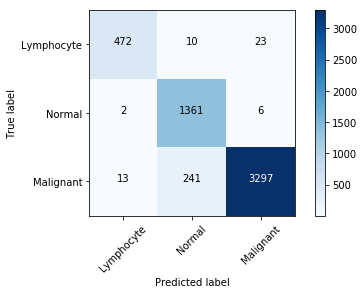

In [4]:
import time

model_loc = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_192_.55-0.92.hdf5'
height = 192

downsample = 2
stride = 2
cutoff=.99
radius = 5
output_class = True

model = load_model(model_loc)
curr_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'

all_files=glob.glob(os.path.join(curr_folder, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
all_xml = [loc for loc in all_files if 'key' in loc]

all_matched_pts = []
all_matched_preds = []
abs_error_list = []
total_nuclei = 0
num_predicted = 0

t0 = time.time()
for image_loc in all_images:
#     print(image_loc)
    heatmap = create_heatmap_2(image_loc=image_loc, model=model, height=height, downsample=downsample)

    image_name = image_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
    xml_loc = os.path.join(curr_folder, image_name+'_key.xml')    

    preds = non_max_supression(heatmap, radius=radius, cutoff=cutoff, stride=stride, output_class=output_class)
    true_points = get_points_xml(xml_loc)

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points

    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
                
    # Add the numbers for each image:
    total_nuclei += len(true_points)
    num_predicted += len(preds)
    abs_error_list = abs(len(true_points)-len(preds))

acc = {}
acc["all_matched_preds"] = np.array(all_matched_preds)
acc["all_matched_pts"] = np.array(all_matched_pts)
acc["total_nuclei"] = total_nuclei
acc["num_predicted"] = num_predicted
acc["abs_error"] = abs_error_list

# acc.to_pickle('/Users/rb/Documents/waterloo/projects/cancer_hist/final/evaluation/acc')
t1 = time.time()
total = t1-t0
print('Time taken: ', total)

###############

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

print(accuracy_score(acc["all_matched_pts"][:,2], acc["all_matched_preds"]))

cm = confusion_matrix(acc["all_matched_pts"][:,2], acc["all_matched_preds"])
classes =['Lymphocyte', 'Normal', 'Malignant']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# add the numbers
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [11]:
# print('% matched / total true: ', len(acc["all_matched_pts"])/float(acc["total_nuclei"]))
      
# print('% pred, not matched / total true: ', (float(acc["num_predicted"])-len(acc["all_matched_pts"]))/float(acc["total_nuclei"]))

# print(acc["total_nuclei"])
# print(acc["num_predicted"])

### Now try for the two-sample method:

/Users/rb/anaconda/envs/py27/lib/python2.7/site-packages/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Time taken:  200.862765074
len(acc["all_matched_preds"]):  5478
0.86546184739


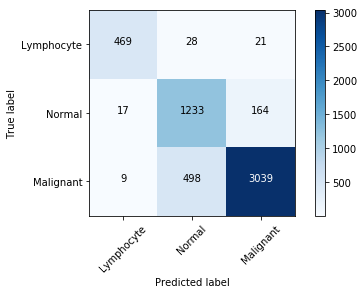

In [3]:
import time

model_loc_1 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_32_.123-0.90.hdf5'
model_loc_2 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_192_.55-0.92.hdf5'
height_1 = 32
height_2 = 192

downsample = 2
stride = 2
cutoff=.99
cutoff_2 = .75
radius = 5
output_class = False

model_1 = load_model(model_loc_1)
model_2 = load_model(model_loc_2)

curr_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'

all_files=glob.glob(os.path.join(curr_folder, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
all_xml = [loc for loc in all_files if 'key' in loc]

all_matched_pts = []
all_matched_preds = []
abs_error_list = []
total_nuclei = 0
num_predicted = 0

t0 = time.time()

for image_loc in all_images:
    heatmap = create_heatmap_2(image_loc=image_loc, model=model_1, height=height_1, downsample=downsample)

    image_name = image_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
    xml_loc = os.path.join(curr_folder, image_name+'_key.xml')    

    preds = non_max_supression(heatmap, radius=radius, cutoff=cutoff, stride=stride, output_class=output_class)
    true_points = get_points_xml(xml_loc)
    
    
    ###########
    new_vals = np.array([np.argmax(point[3:])+1 for point in preds])
    preds = np.column_stack((preds[:, 0:2], new_vals))
    
#     # Update the predictions based on the bigger model:
#     image = np.asarray(Image.open(image_loc))
#     not_update_preds = np.array([point for point in preds if np.amax(point[3:])>=cutoff_2])
#     update_preds = np.array([point for point in preds if np.amax(point[3:])<cutoff_2])

#     new_preds = predict_points(update_preds, model_2, image, 192)

#     # Now change it to a prediction rather than probabilities:
#     new_vals = np.array([np.argmax(point[3:])+1 for point in new_preds])
#     not_update_vals = np.array([np.argmax(point[3:])+1 for point in not_update_preds])

#     not_update_preds = np.column_stack((not_update_preds[:, 0:2], not_update_vals))
#     new_preds = np.column_stack((new_preds[:, 0:2], new_vals))

#     # add the points together:
#     preds = np.concatenate((not_update_preds, new_preds), axis=0)

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points

    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
    
    
    # Add the numbers for each image:
    total_nuclei += len(true_points)
    num_predicted += len(preds)
    abs_error_list = abs(len(true_points)-len(preds))
    
acc = {}
acc["all_matched_preds"] = np.array(all_matched_preds)
acc["all_matched_pts"] = np.array(all_matched_pts)
acc["total_nuclei"] = total_nuclei
acc["num_predicted"] = num_predicted
acc["abs_error"] = abs_error_list

t1 = time.time()
total = t1-t0
print('Time taken: ', total)

###############

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

print('len(acc["all_matched_preds"]): ', len(acc["all_matched_preds"]))
print(accuracy_score(acc["all_matched_pts"][:,2], acc["all_matched_preds"]))

cm = confusion_matrix(acc["all_matched_pts"][:,2], acc["all_matched_preds"])
classes =['Lymphocyte', 'Normal', 'Malignant']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# add the numbers
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Time taken:  705.083214045
updated_num:  2715
len(preds):  96
0.926263916773


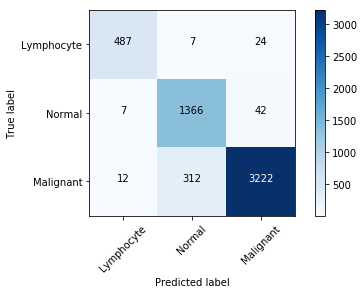

In [4]:
import time

model_loc_1 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_32_.123-0.90.hdf5'
model_loc_2 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_192_.55-0.92.hdf5'
height_1 = 32
height_2 = 192

downsample = 2
stride = 2
cutoff=.99
cutoff_2 = .75
radius = 5
output_class = False

model_1 = load_model(model_loc_1)
model_2 = load_model(model_loc_2)

curr_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'

all_files=glob.glob(os.path.join(curr_folder, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
all_xml = [loc for loc in all_files if 'key' in loc]

all_matched_pts = []
all_matched_preds = []
abs_error_list = []
total_nuclei = 0
num_predicted = 0

t0 = time.time()
updated_num = 0

for image_loc in all_images:
    heatmap = create_heatmap_2(image_loc=image_loc, model=model_1, height=height_1, downsample=downsample)

    image_name = image_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
    xml_loc = os.path.join(curr_folder, image_name+'_key.xml') 

    preds = non_max_supression(heatmap, radius=radius, cutoff=cutoff, stride=stride, output_class=output_class)
    true_points = get_points_xml(xml_loc)
    
    
    ###########
#     new_vals = np.array([np.argmax(point[3:])+1 for point in preds])
#     preds = np.column_stack((preds[:, 0:2], new_vals))
    
    # Update the predictions based on the bigger model:
    image = np.asarray(Image.open(image_loc))
    not_update_preds = np.array([point for point in preds if np.amax(point[3:])>=cutoff_2])
    update_preds = np.array([point for point in preds if np.amax(point[3:])<cutoff_2])
    updated_num += len(update_preds) 

    new_preds = predict_points(update_preds, model_2, image, 192)

    # Now change it to a prediction rather than probabilities:
    # new_vals = np.array([np.argmax(point[3:])+1 for point in new_preds])
    not_update_vals = np.array([np.argmax(point[3:])+1 for point in not_update_preds])

    not_update_preds = np.column_stack((not_update_preds[:, 0:2], not_update_vals))
    # new_preds = np.column_stack((new_preds[:, 0:2], new_vals))

    # add the points together:
    preds = np.concatenate((not_update_preds, new_preds), axis=0)

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points

    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
    
    
    # Add the numbers for each image:
    total_nuclei += len(true_points)
    num_predicted += len(preds)
    abs_error_list = abs(len(true_points)-len(preds))
    
acc = {}
acc["all_matched_preds"] = np.array(all_matched_preds)
acc["all_matched_pts"] = np.array(all_matched_pts)
acc["total_nuclei"] = total_nuclei
acc["num_predicted"] = num_predicted
acc["abs_error"] = abs_error_list

t1 = time.time()
total = t1-t0
print('Time taken: ', total)
print('updated_num: ', updated_num)

###############

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

print('len(preds): ', len(preds))
print(accuracy_score(acc["all_matched_pts"][:,2], acc["all_matched_preds"]))

cm = confusion_matrix(acc["all_matched_pts"][:,2], acc["all_matched_preds"])
classes =['Lymphocyte', 'Normal', 'Malignant']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# add the numbers
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Time taken:  316.184974909
updated_num:  594
len(preds):  96
0.882803943045


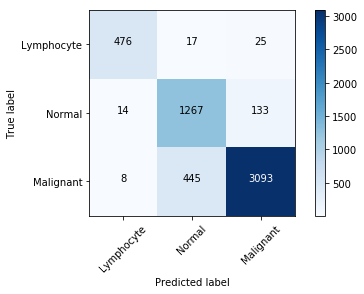

In [5]:
import time

model_loc_1 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_32_.123-0.90.hdf5'
model_loc_2 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_192_.55-0.92.hdf5'
height_1 = 32
height_2 = 192

downsample = 2
stride = 2
cutoff=.99
cutoff_2 = .5
radius = 5
output_class = False

model_1 = load_model(model_loc_1)
model_2 = load_model(model_loc_2)

curr_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'

all_files=glob.glob(os.path.join(curr_folder, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
all_xml = [loc for loc in all_files if 'key' in loc]

all_matched_pts = []
all_matched_preds = []
abs_error_list = []
total_nuclei = 0
num_predicted = 0

t0 = time.time()
updated_num = 0

for image_loc in all_images:
    heatmap = create_heatmap_2(image_loc=image_loc, model=model_1, height=height_1, downsample=downsample)

    image_name = image_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
    xml_loc = os.path.join(curr_folder, image_name+'_key.xml') 

    preds = non_max_supression(heatmap, radius=radius, cutoff=cutoff, stride=stride, output_class=output_class)
    true_points = get_points_xml(xml_loc)
    
    
    ###########
#     new_vals = np.array([np.argmax(point[3:])+1 for point in preds])
#     preds = np.column_stack((preds[:, 0:2], new_vals))
    
    # Update the predictions based on the bigger model:
    image = np.asarray(Image.open(image_loc))
    not_update_preds = np.array([point for point in preds if np.amax(point[3:])>=cutoff_2])
    update_preds = np.array([point for point in preds if np.amax(point[3:])<cutoff_2])
    updated_num += len(update_preds) 

    new_preds = predict_points(update_preds, model_2, image, 192)

    # Now change it to a prediction rather than probabilities:
    # new_vals = np.array([np.argmax(point[3:])+1 for point in new_preds])
    not_update_vals = np.array([np.argmax(point[3:])+1 for point in not_update_preds])

    not_update_preds = np.column_stack((not_update_preds[:, 0:2], not_update_vals))
    # new_preds = np.column_stack((new_preds[:, 0:2], new_vals))

    # add the points together:
    preds = np.concatenate((not_update_preds, new_preds), axis=0)

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points

    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
    
    
    # Add the numbers for each image:
    total_nuclei += len(true_points)
    num_predicted += len(preds)
    abs_error_list = abs(len(true_points)-len(preds))
    
acc = {}
acc["all_matched_preds"] = np.array(all_matched_preds)
acc["all_matched_pts"] = np.array(all_matched_pts)
acc["total_nuclei"] = total_nuclei
acc["num_predicted"] = num_predicted
acc["abs_error"] = abs_error_list

t1 = time.time()
total = t1-t0
print('Time taken: ', total)
print('updated_num: ', updated_num)

###############

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

print('len(preds): ', len(preds))
print(accuracy_score(acc["all_matched_pts"][:,2], acc["all_matched_preds"]))

cm = confusion_matrix(acc["all_matched_pts"][:,2], acc["all_matched_preds"])
classes =['Lymphocyte', 'Normal', 'Malignant']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# add the numbers
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Time taken:  1222.02121997
updated_num:  5264
len(preds):  96
0.943957648777


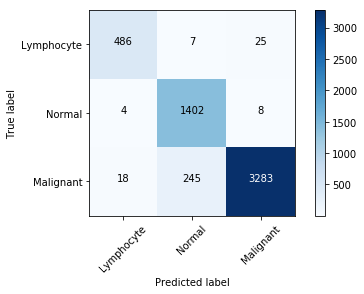

In [6]:
import time

model_loc_1 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_32_.123-0.90.hdf5'
model_loc_2 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_192_.55-0.92.hdf5'
height_1 = 32
height_2 = 192

downsample = 2
stride = 2
cutoff=.99
cutoff_2 = .9
radius = 5
output_class = False

model_1 = load_model(model_loc_1)
model_2 = load_model(model_loc_2)

curr_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'

all_files=glob.glob(os.path.join(curr_folder, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
all_xml = [loc for loc in all_files if 'key' in loc]

all_matched_pts = []
all_matched_preds = []
abs_error_list = []
total_nuclei = 0
num_predicted = 0

t0 = time.time()
updated_num = 0

for image_loc in all_images:
    heatmap = create_heatmap_2(image_loc=image_loc, model=model_1, height=height_1, downsample=downsample)

    image_name = image_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
    xml_loc = os.path.join(curr_folder, image_name+'_key.xml') 

    preds = non_max_supression(heatmap, radius=radius, cutoff=cutoff, stride=stride, output_class=output_class)
    true_points = get_points_xml(xml_loc)
    
    
    ###########
#     new_vals = np.array([np.argmax(point[3:])+1 for point in preds])
#     preds = np.column_stack((preds[:, 0:2], new_vals))
    
    # Update the predictions based on the bigger model:
    image = np.asarray(Image.open(image_loc))
    not_update_preds = np.array([point for point in preds if np.amax(point[3:])>=cutoff_2])
    update_preds = np.array([point for point in preds if np.amax(point[3:])<cutoff_2])
    updated_num += len(update_preds) 

    new_preds = predict_points(update_preds, model_2, image, 192)

    # Now change it to a prediction rather than probabilities:
    # new_vals = np.array([np.argmax(point[3:])+1 for point in new_preds])
    not_update_vals = np.array([np.argmax(point[3:])+1 for point in not_update_preds])

    not_update_preds = np.column_stack((not_update_preds[:, 0:2], not_update_vals))
    # new_preds = np.column_stack((new_preds[:, 0:2], new_vals))

    # add the points together:
    preds = np.concatenate((not_update_preds, new_preds), axis=0)

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points

    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
    
    
    # Add the numbers for each image:
    total_nuclei += len(true_points)
    num_predicted += len(preds)
    abs_error_list = abs(len(true_points)-len(preds))
    
acc = {}
acc["all_matched_preds"] = np.array(all_matched_preds)
acc["all_matched_pts"] = np.array(all_matched_pts)
acc["total_nuclei"] = total_nuclei
acc["num_predicted"] = num_predicted
acc["abs_error"] = abs_error_list

t1 = time.time()
total = t1-t0
print('Time taken: ', total)
print('updated_num: ', updated_num)

###############

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

print('len(preds): ', len(preds))
print(accuracy_score(acc["all_matched_pts"][:,2], acc["all_matched_preds"]))

cm = confusion_matrix(acc["all_matched_pts"][:,2], acc["all_matched_preds"])
classes =['Lymphocyte', 'Normal', 'Malignant']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# add the numbers
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Time taken:  738.857667923
updated_num:  2050
len(preds):  138
0.953212290503


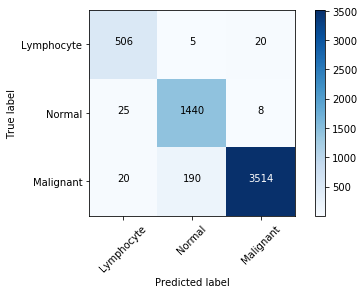

In [5]:
import time

model_loc_1 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_64_.156-0.92.hdf5'
model_loc_2 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_192_.55-0.92.hdf5'
height_1 = 64
height_2 = 192

downsample = 2
stride = 2
cutoff=.99
cutoff_2 = .75
radius = 5
output_class = False

model_1 = load_model(model_loc_1)
model_2 = load_model(model_loc_2)

curr_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'

all_files=glob.glob(os.path.join(curr_folder, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
all_xml = [loc for loc in all_files if 'key' in loc]

all_matched_pts = []
all_matched_preds = []
abs_error_list = []
total_nuclei = 0
num_predicted = 0

t0 = time.time()
updated_num = 0

for image_loc in all_images:
    heatmap = create_heatmap_2(image_loc=image_loc, model=model_1, height=height_1, downsample=downsample)

    image_name = image_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
    xml_loc = os.path.join(curr_folder, image_name+'_key.xml') 

    preds = non_max_supression(heatmap, radius=radius, cutoff=cutoff, stride=stride, output_class=output_class)
    true_points = get_points_xml(xml_loc)
    
    
    ###########
#     new_vals = np.array([np.argmax(point[3:])+1 for point in preds])
#     preds = np.column_stack((preds[:, 0:2], new_vals))
    
    # Update the predictions based on the bigger model:
    image = np.asarray(Image.open(image_loc))
    not_update_preds = np.array([point for point in preds if np.amax(point[3:])>=cutoff_2])
    update_preds = np.array([point for point in preds if np.amax(point[3:])<cutoff_2])
    updated_num += len(update_preds) 

    new_preds = predict_points(update_preds, model_2, image, 192)

    # Now change it to a prediction rather than probabilities:
    # new_vals = np.array([np.argmax(point[3:])+1 for point in new_preds])
    not_update_vals = np.array([np.argmax(point[3:])+1 for point in not_update_preds])

    not_update_preds = np.column_stack((not_update_preds[:, 0:2], not_update_vals))
    # new_preds = np.column_stack((new_preds[:, 0:2], new_vals))

    # add the points together:
    preds = np.concatenate((not_update_preds, new_preds), axis=0)

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points

    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
    
    
    # Add the numbers for each image:
    total_nuclei += len(true_points)
    num_predicted += len(preds)
    abs_error_list = abs(len(true_points)-len(preds))
    
acc = {}
acc["all_matched_preds"] = np.array(all_matched_preds)
acc["all_matched_pts"] = np.array(all_matched_pts)
acc["total_nuclei"] = total_nuclei
acc["num_predicted"] = num_predicted
acc["abs_error"] = abs_error_list

t1 = time.time()
total = t1-t0
print('Time taken: ', total)
print('updated_num: ', updated_num)

###############

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

print('len(preds): ', len(preds))
print(accuracy_score(acc["all_matched_pts"][:,2], acc["all_matched_preds"]))

cm = confusion_matrix(acc["all_matched_pts"][:,2], acc["all_matched_preds"])
classes =['Lymphocyte', 'Normal', 'Malignant']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# add the numbers
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Time taken:  4537.003196
updated_num:  957
len(preds):  138
0.952863128492


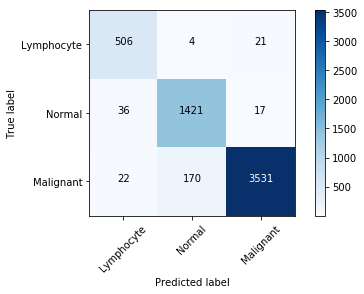

In [29]:
import time

model_loc_1 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_64_.156-0.92.hdf5'
model_loc_2 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_192_.55-0.92.hdf5'
height_1 = 64
height_2 = 192

downsample = 2
stride = 2
cutoff=.995
cutoff_2 = .6
radius = 5
output_class = False

model_1 = load_model(model_loc_1)
model_2 = load_model(model_loc_2)

curr_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'

all_files=glob.glob(os.path.join(curr_folder, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
all_xml = [loc for loc in all_files if 'key' in loc]

all_matched_pts = []
all_matched_preds = []
abs_error_list = []
total_nuclei = 0
num_predicted = 0

t0 = time.time()
updated_num = 0

for image_loc in all_images:
    heatmap = create_heatmap_2(image_loc=image_loc, model=model_1, height=height_1, downsample=downsample)

    image_name = image_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
    xml_loc = os.path.join(curr_folder, image_name+'_key.xml') 

    preds = non_max_supression(heatmap, radius=radius, cutoff=cutoff, stride=stride, output_class=output_class)
    true_points = get_points_xml(xml_loc)
    
    
    ###########
#     new_vals = np.array([np.argmax(point[3:])+1 for point in preds])
#     preds = np.column_stack((preds[:, 0:2], new_vals))
    
    # Update the predictions based on the bigger model:
    image = np.asarray(Image.open(image_loc))
    not_update_preds = np.array([point for point in preds if np.amax(point[3:])>=cutoff_2])
    update_preds = np.array([point for point in preds if np.amax(point[3:])<cutoff_2])
    updated_num += len(update_preds) 

    new_preds = predict_points(update_preds, model_2, image, 192)

    # Now change it to a prediction rather than probabilities:
    # new_vals = np.array([np.argmax(point[3:])+1 for point in new_preds])
    not_update_vals = np.array([np.argmax(point[3:])+1 for point in not_update_preds])

    not_update_preds = np.column_stack((not_update_preds[:, 0:2], not_update_vals))
    # new_preds = np.column_stack((new_preds[:, 0:2], new_vals))

    # add the points together:
    preds = np.concatenate((not_update_preds, new_preds), axis=0)

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points

    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
    
    
    # Add the numbers for each image:
    total_nuclei += len(true_points)
    num_predicted += len(preds)
    abs_error_list = abs(len(true_points)-len(preds))
    
acc = {}
acc["all_matched_preds"] = np.array(all_matched_preds)
acc["all_matched_pts"] = np.array(all_matched_pts)
acc["total_nuclei"] = total_nuclei
acc["num_predicted"] = num_predicted
acc["abs_error"] = abs_error_list

t1 = time.time()
total = t1-t0
print('Time taken: ', total)
print('updated_num: ', updated_num)

###############

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

print('len(preds): ', len(preds))
print(accuracy_score(acc["all_matched_pts"][:,2], acc["all_matched_preds"]))

cm = confusion_matrix(acc["all_matched_pts"][:,2], acc["all_matched_preds"])
classes =['Lymphocyte', 'Normal', 'Malignant']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# add the numbers
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
print('% matched / total true: ', len(acc["all_matched_pts"])/float(acc["total_nuclei"]))
      
print('% pred, not matched / total true: ', (float(acc["num_predicted"])-len(acc["all_matched_pts"]))/float(acc["total_nuclei"]))

print(acc["total_nuclei"])
print(acc["num_predicted"])

% matched / total true:  0.910941475827
% pred, not matched / total true:  0.576972010178
6288
9356


In [32]:
# LYMPHOCYTE
acc = np.float((np.sum(cm[0, 0]) + np.sum(cm[1:, 1:])))/np.float(np.sum(cm))
# TP/(TP+FN) proportion of positives that are correctly identified as such
sensitivity = np.float(np.sum(cm[0, 0]))/np.float(np.sum(cm[0, :]))
# TN/(TN+FP) prop of negative correctly identified
specificity = np.float(np.sum(cm[1:, 1:]))/np.float(np.sum(cm[1:, :]))
print('Lymphocyte: ', acc, sensitivity, specificity)

# NORMAL
acc = np.float(cm[1, 1] + cm[0, 0]+ cm[0, 2]+ cm[2, 0]+ cm[2, 2])/np.float(np.sum(cm))
# TP/(TP+FN) proportion of positives that are correctly identified as such
sensitivity = np.float(np.sum(cm[1, 1]))/np.float(np.sum(cm[1,:]))
# TN/(TN+FP) prop of negative correctly identified
specificity = np.float(np.float(cm[0, 0]+ cm[0, 2]+ cm[2, 0]+ cm[2, 2]))/np.float(np.sum(cm[0, :])+np.sum(cm[2, :]))
print('Normal: ', acc, sensitivity, specificity)

# MALIGNANT
acc = np.float((np.sum(cm[2, 2]) + np.sum(cm[:2, :2])))/np.float(np.sum(cm))
# TP/(TP+FN) proportion of positives that are correctly identified as such
sensitivity = np.float(np.sum(cm[2, 2]))/np.float(np.sum(cm[2, :]))
# TN/(TN+FP) prop of negative correctly identified
specificity = np.float(np.sum(cm[:2, :2]))/np.float(np.sum(cm[:2, :]))
print('Malignant: ', acc, sensitivity, specificity)                    

Lymphocyte:  0.985509776536 0.952919020716 0.98883971522
Normal:  0.960370111732 0.964043419267 0.959097320169
Malignant:  0.959846368715 0.948428686543 0.981047381546


# Test the uncertainty


In [12]:
import time

model_loc = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_192_.55-0.92.hdf5'
height = 192

downsample = 2
stride = 2
cutoff=.99
radius = 5
output_class = False

model = load_model(model_loc)
curr_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'

all_files=glob.glob(os.path.join(curr_folder, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
all_xml = [loc for loc in all_files if 'key' in loc]

all_matched_pts = []
all_matched_preds = []
abs_error_list = []
total_nuclei = 0
num_predicted = 0

t0 = time.time()
for image_loc in all_images:
#     print(image_loc)
    heatmap = create_heatmap_2(image_loc=image_loc, model=model, height=height, downsample=downsample)

    image_name = image_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
    xml_loc = os.path.join(curr_folder, image_name+'_key.xml')    

    preds = non_max_supression(heatmap, radius=radius, cutoff=cutoff, stride=stride, output_class=output_class)
    true_points = get_points_xml(xml_loc)

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points

    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
                
    # Add the numbers for each image:
    total_nuclei += len(true_points)
    num_predicted += len(preds)
    abs_error_list = abs(len(true_points)-len(preds))

acc = {}
acc["all_matched_preds"] = np.array(all_matched_preds)
acc["all_matched_pts"] = np.array(all_matched_pts)
acc["total_nuclei"] = total_nuclei
acc["num_predicted"] = num_predicted
acc["abs_error"] = abs_error_list

t1 = time.time()
total = t1-t0
print('Time taken: ', total)

Time taken:  1770.51105404


In [15]:
print(acc["all_matched_preds"])
print(acc["all_matched_pts"])


[[ 1.          0.04192058  0.04192058  0.91615885]
 [ 1.          0.06028188  0.03252846  0.90718967]
 [ 1.          0.02237215  0.02237215  0.95525563]
 ..., 
 [ 1.          0.07321361  0.28152561  0.64526075]
 [ 1.          0.08560532  0.25392166  0.66047305]
 [ 0.91029096  0.05337507  0.05337507  0.89324987]]
[[  15.  128.    3.]
 [  35.  528.    3.]
 [  38.   64.    3.]
 ..., 
 [ 447.   42.    3.]
 [ 450.  443.    3.]
 [ 128.  254.    3.]]


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

preds = acc["all_matched_preds"]
preds[:,0] = acc["all_matched_pts"][:, 2]

cutoff_list = [.3, .4, .5, .6, .7, .8, .9, .92, .95, .97, .99]

for cutoff in cutoff_list:
    certain_preds = np.array([point for point in preds if np.amax(point[1:])>cutoff])
    class_preds = np.array([np.argmax(point[1:])+1 for point in certain_preds])
    print('cutoff: ', cutoff, ' accuracy_score: ', accuracy_score(certain_preds[:,0], class_preds), 'len(class_preds): ', len(class_preds))

cutoff:  0.3  accuracy_score:  0.945622119816 len(class_preds):  5425
cutoff:  0.4  accuracy_score:  0.946300055361 len(class_preds):  5419
cutoff:  0.5  accuracy_score:  0.954914167138 len(class_preds):  5301
cutoff:  0.6  accuracy_score:  0.969649191959 len(class_preds):  5074
cutoff:  0.7  accuracy_score:  0.983146067416 len(class_preds):  4806
cutoff:  0.8  accuracy_score:  0.991134348716 len(class_preds):  4399
cutoff:  0.9  accuracy_score:  0.997769102064 len(class_preds):  3586
cutoff:  0.92  accuracy_score:  0.99784150478 len(class_preds):  3243
cutoff:  0.95  accuracy_score:  1.0 len(class_preds):  2410
cutoff:  0.97  accuracy_score:  1.0 len(class_preds):  1583
cutoff:  0.99  accuracy_score:  1.0 len(class_preds):  376


In [24]:
import time

model_loc = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_64_.156-0.92.hdf5'
height = 64

downsample = 2
stride = 2
cutoff=.995
radius = 5
output_class = False

model = load_model(model_loc)
curr_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'

all_files=glob.glob(os.path.join(curr_folder, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
all_xml = [loc for loc in all_files if 'key' in loc]

all_matched_pts = []
all_matched_preds = []
abs_error_list = []
total_nuclei = 0
num_predicted = 0

t0 = time.time()
for image_loc in all_images:
#     print(image_loc)
    heatmap = create_heatmap_2(image_loc=image_loc, model=model, height=height, downsample=downsample)

    image_name = image_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
    xml_loc = os.path.join(curr_folder, image_name+'_key.xml')    

    preds = non_max_supression(heatmap, radius=radius, cutoff=cutoff, stride=stride, output_class=output_class)
    true_points = get_points_xml(xml_loc)

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points

    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
                
    # Add the numbers for each image:
    total_nuclei += len(true_points)
    num_predicted += len(preds)
    abs_error_list = abs(len(true_points)-len(preds))

acc64 = {}
acc64["all_matched_preds"] = np.array(all_matched_preds)
acc64["all_matched_pts"] = np.array(all_matched_pts)
acc64["total_nuclei"] = total_nuclei
acc64["num_predicted"] = num_predicted
acc64["abs_error"] = abs_error_list

t1 = time.time()
total = t1-t0
print('Time taken: ', total)

Time taken:  381.616122961


In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

preds = acc64["all_matched_preds"]
preds[:,0] = acc64["all_matched_pts"][:, 2]

cutoff_list = [.4, .5, .6, .7, .8, .9, .92, .95, .97, .99]

for cutoff in cutoff_list:
    certain_preds = np.array([point for point in preds if np.amax(point[1:])>cutoff])
    class_preds = np.array([np.argmax(point[1:])+1 for point in certain_preds])
    print('cutoff: ', cutoff, ' accuracy_score: ', accuracy_score(certain_preds[:,0], class_preds), 'len(class_preds): ', len(class_preds))

cutoff:  0.4  accuracy_score:  0.938671806553 len(class_preds):  5707
cutoff:  0.5  accuracy_score:  0.951691695314 len(class_preds):  5527
cutoff:  0.6  accuracy_score:  0.969140477092 len(class_preds):  5282
cutoff:  0.7  accuracy_score:  0.979637096774 len(class_preds):  4960
cutoff:  0.8  accuracy_score:  0.988306723634 len(class_preds):  4447
cutoff:  0.9  accuracy_score:  0.996787383178 len(class_preds):  3424
cutoff:  0.92  accuracy_score:  0.997030682943 len(class_preds):  3031
cutoff:  0.95  accuracy_score:  0.997825141366 len(class_preds):  2299
cutoff:  0.97  accuracy_score:  0.999321113374 len(class_preds):  1473
cutoff:  0.99  accuracy_score:  1.0 len(class_preds):  439


Time taken:  602.202569962
updated_num:  1376
len(preds):  96
0.899799233437


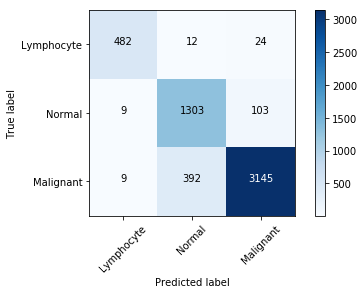

In [28]:
import time

model_loc_1 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_32_.123-0.90.hdf5'
model_loc_2 = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/conv_incp3/conv_incp3_192_.55-0.92.hdf5'
height_1 = 32
height_2 = 192

downsample = 2
stride = 2
cutoff=.99
cutoff_2 = .6
radius = 5
output_class = False

model_1 = load_model(model_loc_1)
model_2 = load_model(model_loc_2)

curr_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'

all_files=glob.glob(os.path.join(curr_folder, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
all_xml = [loc for loc in all_files if 'key' in loc]

all_matched_pts = []
all_matched_preds = []
abs_error_list = []
total_nuclei = 0
num_predicted = 0

t0 = time.time()
updated_num = 0

for image_loc in all_images:
    heatmap = create_heatmap_2(image_loc=image_loc, model=model_1, height=height_1, downsample=downsample)

    image_name = image_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
    xml_loc = os.path.join(curr_folder, image_name+'_key.xml') 

    preds = non_max_supression(heatmap, radius=radius, cutoff=cutoff, stride=stride, output_class=output_class)
    true_points = get_points_xml(xml_loc)
    
    
    ###########
#     new_vals = np.array([np.argmax(point[3:])+1 for point in preds])
#     preds = np.column_stack((preds[:, 0:2], new_vals))
    
    # Update the predictions based on the bigger model:
    image = np.asarray(Image.open(image_loc))
    not_update_preds = np.array([point for point in preds if np.amax(point[3:])>=cutoff_2])
    update_preds = np.array([point for point in preds if np.amax(point[3:])<cutoff_2])
    updated_num += len(update_preds) 

    new_preds = predict_points(update_preds, model_2, image, 192)

    # Now change it to a prediction rather than probabilities:
    # new_vals = np.array([np.argmax(point[3:])+1 for point in new_preds])
    not_update_vals = np.array([np.argmax(point[3:])+1 for point in not_update_preds])

    not_update_preds = np.column_stack((not_update_preds[:, 0:2], not_update_vals))
    # new_preds = np.column_stack((new_preds[:, 0:2], new_vals))

    # add the points together:
    preds = np.concatenate((not_update_preds, new_preds), axis=0)

    #loop through the predictions, and check if there a corresponding true point
    # Delete the true points once they are matched, so they are not mached more than once
    tp_temp = true_points

    for index, point in enumerate(preds):
        dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
        if (len(dists)==0):
            break
        else:
            min_ind = np.argmin(dists)
            # if point has matching prediction, append it and increment the number of matched points
            if (dists[min_ind] < 10):
                all_matched_preds.append(preds[index, 2:])
                all_matched_pts.append(tp_temp[min_ind, :])
                tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list
    
    
    # Add the numbers for each image:
    total_nuclei += len(true_points)
    num_predicted += len(preds)
    abs_error_list = abs(len(true_points)-len(preds))
    
acc = {}
acc["all_matched_preds"] = np.array(all_matched_preds)
acc["all_matched_pts"] = np.array(all_matched_pts)
acc["total_nuclei"] = total_nuclei
acc["num_predicted"] = num_predicted
acc["abs_error"] = abs_error_list

t1 = time.time()
total = t1-t0
print('Time taken: ', total)
print('updated_num: ', updated_num)

###############

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

print('len(preds): ', len(preds))
print(accuracy_score(acc["all_matched_pts"][:,2], acc["all_matched_preds"]))

cm = confusion_matrix(acc["all_matched_pts"][:,2], acc["all_matched_preds"])
classes =['Lymphocyte', 'Normal', 'Malignant']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# add the numbers
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()